In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import copy
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

# Generate Data

In [2]:
#Import data
data = pd.read_csv('./data/pbc.csv')
t = np.array(data['t'])
delta = np.array(data['delta'])
delta[delta ==1.] = 0
delta[delta==2.] = 1
trt = np.array(data['trt'])

#Split into treatments (filtering NA)
t1 = t[trt == 1.]
delta1 = delta[trt==1.]

t2 = t[trt == 2.]
delta2 = delta[trt==2.]

#Normalize
#Treatment
scale1 = np.sum(t1)/np.sum(delta1)
t1_norm = t1/scale1

#Placebo
scale2 = np.sum(t2)/np.sum(delta2)
t2_norm = t2/scale2

#Same as run script
y_plot = np.array(pd.read_csv('data/pbc_y_plot.csv',header = None)).reshape(-1)
dy = y_plot[1] - y_plot[0]

# Copula Method

## Placebo

In [3]:
#Load copula
ESS_copula = np.load('plot_files/pbc2_ESS_copula.npy')
particle_ind_copula = np.load('plot_files/pbc2_particle_ind_copula.npy')
logpdf_av_copula = np.load('plot_files/pbc2_logpdf_av_copula.npy')
logcdf_av_copula = np.load('plot_files/pbc2_logcdf_av_copula.npy')
logpdf_pr_copula = np.load('plot_files/pbc2_logpdf_samp_copula.npy')
logcdf_pr_copula = np.load('plot_files/pbc2_logcdf_samp_copula.npy')
pdiff_copula = np.load('plot_files/pbc2_pdiff_copula.npy')
cdiff_copula = np.load('plot_files/pbc2_cdiff_copula.npy')
a_opt_copula = np.load('plot_files/pbc2_a_copula.npy')

cdf_av_copula = np.exp(logcdf_av_copula)
pdf_av_copula = np.exp(logpdf_av_copula)
cdf_pr_copula = np.exp(logcdf_pr_copula)
pdf_pr_copula = np.exp(logpdf_pr_copula)


#Load DPMM
pdf_samp_dpmm = np.array(pd.read_csv("plot_files/pbc2_pdf_samp_dpmm.csv").iloc[:,1:])
cdf_samp_dpmm = np.array(pd.read_csv("plot_files/pbc2_cdf_samp_dpmm.csv").iloc[:,1:])

n= np.shape(t2_norm)[0]

/Users/efong/virtualenv/surv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/efong/virtualenv/surv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


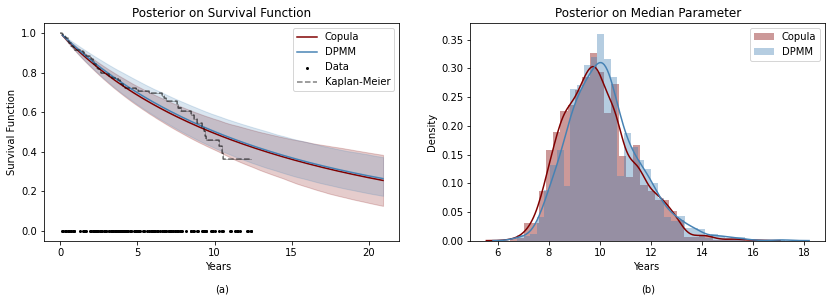

In [4]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(t2_norm*scale2/365, event_observed=delta2,alpha = 0.999)


#f =plt.figure(figsize=(14,4))
f, axes = plt.subplots(2, 1, figsize=(14, 4), sharex=True)
plt.subplot(1,2,1)
bot25 = np.percentile(1-cdf_pr_copula,2.5,axis = 0)
top25 = np.percentile(1-cdf_pr_copula,97.5,axis = 0)
plt.plot((scale2/365)*y_plot,np.mean(1-cdf_pr_copula,axis = 0), color = 'maroon',label = 'Copula')
plt.fill_between((scale2/365)*y_plot, bot25,top25,alpha = 0.2,color = 'maroon')

bot25 = np.percentile(1-cdf_samp_dpmm,2.5,axis = 0)
top25 = np.percentile(1-cdf_samp_dpmm,97.5,axis = 0)
plt.plot((scale2/365)*y_plot,np.mean(1-cdf_samp_dpmm,axis = 0), color = 'steelblue',label = 'DPMM')
plt.fill_between((scale2/365)*y_plot, bot25,top25,alpha = 0.2,color = 'steelblue')

plt.scatter((scale2/365)*t2_norm,np.zeros(n),color = "k",s =4,label = 'Data')
plt.title('Posterior on Survival Function')
plt.ylabel('Survival Function')
plt.legend()
kmf.plot(color = 'k',alpha = 0.5,label = 'Kaplan-Meier',linestyle = '--')
ylim = plt.ylim()
plt.xlabel('Years  \n \n(a)')


plt.subplot(1,2,2)
theta_copula = y_plot[np.argmin(np.abs(cdf_pr_copula - 0.5),axis = 1)]*scale2/365
theta_dpmm = y_plot[np.argmin(np.abs(cdf_samp_dpmm - 0.5),axis = 1)]*scale2/365
sns.distplot(theta_copula,label = 'Copula',color = 'maroon')
sns.distplot(theta_dpmm,label = 'DPMM',color = 'steelblue')
plt.title('Posterior on Median Parameter')
plt.xlabel('Years \n \n(b)')
plt.legend()

f.savefig("plots/pbc2_surv_median.pdf",bbox_inches='tight')

# Supplementary Experiments

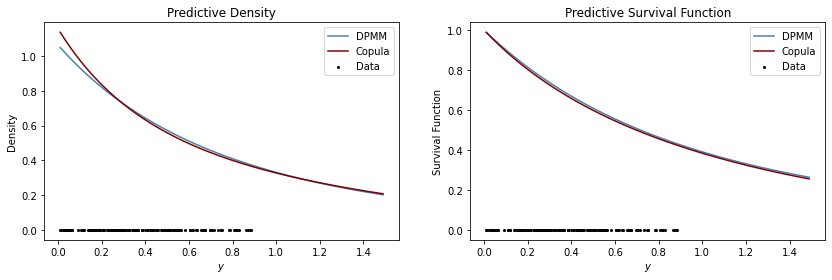

In [5]:
#Compute predictive density values
f =plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(y_plot, np.mean(pdf_samp_dpmm,axis = 0),color = 'steelblue',label = 'DPMM')
plt.plot(y_plot,np.exp(logpdf_av_copula),color = 'maroon',label = 'Copula')
plt.scatter(t2_norm,np.zeros(n),color = "k",s =4,label = 'Data')
plt.title('Predictive Density')
plt.xlabel(r'$y$')
plt.ylabel('Density')
plt.legend()

#survival
plt.subplot(1,2,2)
plt.title('Predictive Survival Function')
plt.plot(y_plot, 1-np.mean(cdf_samp_dpmm,axis = 0),color = 'steelblue',label = 'DPMM')
plt.plot(y_plot,1-np.exp(logcdf_av_copula),color = 'maroon',label =  'Copula')
plt.scatter(t2_norm,np.zeros(n),color = "k",s =4,label = 'Data')
plt.xlabel(r'$y$')
plt.ylabel('Survival Function')
plt.legend()
f.savefig("plots/pbc2_cop_pred.pdf",bbox_inches='tight')


### Predictive resampling

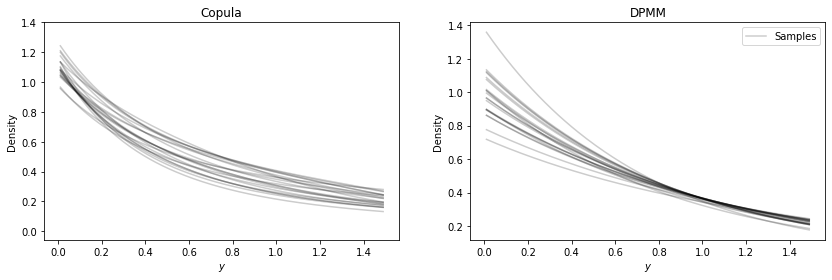

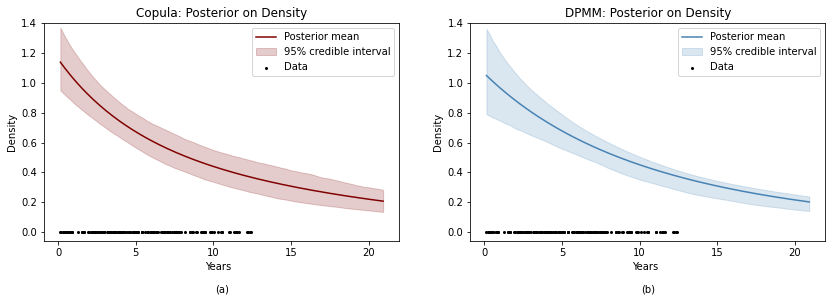

In [6]:
#Plot samples
f =plt.figure(figsize=(14,4))
ylim = (-0.05701138823409359, 1.400282863725433)
plt.subplot(1,2,1)
pdf_pr_copula = np.exp(logpdf_pr_copula)
for i in range(20):
    plt.plot(y_plot,pdf_pr_copula[i], color = 'k',alpha = 0.2)
plt.plot(y_plot,pdf_pr_copula[i+1], color = 'k',alpha = 0.2,label = 'Samples')
plt.title('Copula')
plt.xlabel(r'$y$')
plt.ylabel('Density')
plt.ylim(ylim)


plt.subplot(1,2,2)
for i in range(20):
    plt.plot(y_plot,pdf_samp_dpmm[i], color = 'k',alpha = 0.2)
plt.plot(y_plot,pdf_samp_dpmm[i+1], color = 'k',alpha = 0.2,label = 'Samples')
plt.title('DPMM')
plt.xlabel(r'$y$')
plt.ylabel('Density')
plt.legend()
f.savefig("plots/pbc2_cop_pdf_samp.pdf",bbox_inches='tight')


#Quantiles
f =plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

bot25 = np.percentile(pdf_pr_copula,2.5,axis = 0)
top25 = np.percentile(pdf_pr_copula,97.5,axis = 0)
plt.plot(y_plot*scale2/365,np.mean(pdf_pr_copula,axis = 0), color = 'maroon',label = 'Posterior mean')
plt.fill_between(y_plot*scale2/365, bot25,top25,alpha = 0.2, label = '95% credible interval',color = 'maroon')
plt.scatter(t2_norm*scale2/365,np.zeros(n),color = "k",s =4,label = 'Data')
plt.title('Copula: Posterior on Density')
plt.xlabel('Years  \n \n(a)')
plt.ylabel('Density')
plt.ylim(ylim)
plt.legend()

plt.subplot(1,2,2)

bot25 = np.percentile(pdf_samp_dpmm,2.5,axis = 0)
top25 = np.percentile(pdf_samp_dpmm,97.5,axis = 0)
plt.plot(y_plot*scale2/365,np.mean(pdf_samp_dpmm,axis = 0), color = 'steelblue',label = 'Posterior mean')
plt.fill_between(y_plot*scale2/365, bot25,top25,alpha = 0.2, label = '95% credible interval',color = 'steelblue')
plt.scatter(t2_norm*scale2/365,np.zeros(n),color = "k",s =4,label = 'Data')
plt.title('DPMM: Posterior on Density')
plt.xlabel('Years  \n \n(b)')
plt.ylabel('Density')
plt.ylim(ylim)
plt.legend()
f.savefig("plots/pbc2_cop_pdf_cred.pdf",bbox_inches='tight')


##  Diagnostics

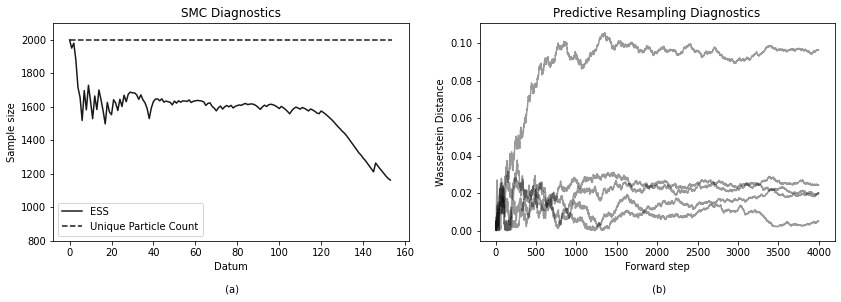

In [7]:
f =plt.figure(figsize=(14,4))
#SMC weight diagnostics
plt.subplot(1,2,1)
plt.plot(ESS_copula,label = 'ESS',color = 'k',alpha = 0.9)
plt.title('SMC Diagnostics')
n_unique = np.zeros(n+1)
for i in range(n+1):
    n_unique[i] = np.shape(np.unique(particle_ind_copula[i]))[0]
plt.plot(n_unique,label = 'Unique Particle Count',color = 'k',alpha = 0.9,linestyle = '--')
plt.xlabel('Datum'+ '\n\n (a)')
plt.ylabel('Sample size')
plt.legend(loc = 3)
plt.ylim(800,2100)


plt.subplot(1,2,2)
plt.title('Predictive Resampling Diagnostics')
T_d = 4000
for i in range(5):
    plt.plot(np.arange(T_d), cdiff_copula[0:T_d,i]*dy*np.shape(y_plot)[0], color = 'k',alpha = 0.4)
plt.xlabel('Forward step'+ '\n\n (b)')
plt.ylabel(r'Wasserstein Distance')
f.savefig("plots/pbc2_diagnostics.pdf",bbox_inches='tight')


# Treatment

In [8]:
#Load copula
ESS_copula_trt = np.load('plot_files/pbc1_ESS_copula.npy')
particle_ind_copula_trt = np.load('plot_files/pbc1_particle_ind_copula.npy')
logpdf_av_copula_trt = np.load('plot_files/pbc1_logpdf_av_copula.npy')
logcdf_av_copula_trt = np.load('plot_files/pbc1_logcdf_av_copula.npy')
logpdf_pr_copula_trt = np.load('plot_files/pbc1_logpdf_samp_copula.npy')
logcdf_pr_copula_trt = np.load('plot_files/pbc1_logcdf_samp_copula.npy')
pdiff_copula_trt = np.load('plot_files/pbc1_pdiff_copula.npy')
cdiff_copula_trt = np.load('plot_files/pbc1_cdiff_copula.npy')
a_opt_copula_trt = np.load('plot_files/pbc1_a_copula.npy')


cdf_av_copula_trt = np.exp(logcdf_av_copula_trt)
pdf_av_copula_trt = np.exp(logpdf_av_copula_trt)
cdf_pr_copula_trt = np.exp(logcdf_pr_copula_trt)
pdf_pr_copula_trt = np.exp(logpdf_pr_copula_trt)

#Load DPMM
pdf_samp_dpmm_trt = np.array(pd.read_csv("plot_files/pbc1_pdf_samp_dpmm.csv").iloc[:,1:])
cdf_samp_dpmm_trt = np.array(pd.read_csv("plot_files/pbc1_cdf_samp_dpmm.csv").iloc[:,1:])

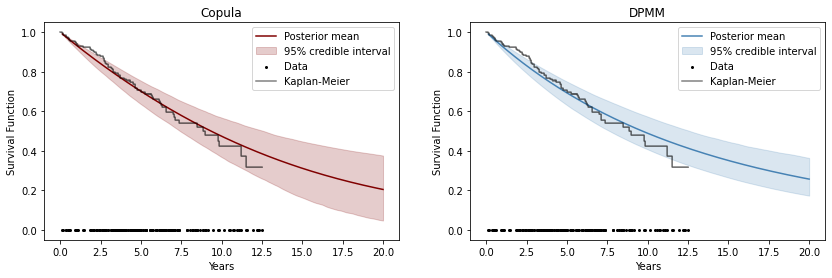

In [9]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(t1_norm*scale1/365, event_observed=delta1,alpha = 0.999)
n1 = np.shape(t1_norm)[0]
cdf_pr_copula_trt = np.exp(logcdf_pr_copula_trt)
f =plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
bot25 = np.percentile(1-cdf_pr_copula_trt,2.5,axis = 0)
top25 = np.percentile(1-cdf_pr_copula_trt,97.5,axis = 0)
plt.plot((scale1/365)*y_plot,np.mean(1-cdf_pr_copula_trt,axis = 0), color = 'maroon',label = 'Posterior mean')
plt.fill_between((scale1/365)*y_plot, bot25,top25,alpha = 0.2, label = '95% credible interval',color = 'maroon')
plt.scatter((scale1/365)*t1_norm,np.zeros(n1),color = "k",s =4,label = 'Data')
plt.title('Copula')
plt.ylabel('Survival Function')
plt.legend()
kmf.plot(color = 'k',alpha = 0.5,label = 'Kaplan-Meier')
ylim = plt.ylim()
plt.xlabel(r'Years')


plt.subplot(1,2,2)

bot25 = np.percentile(1-cdf_samp_dpmm_trt,2.5,axis = 0)
top25 = np.percentile(1-cdf_samp_dpmm_trt,97.5,axis = 0)
plt.plot((scale1/365)*y_plot,np.mean(1-cdf_samp_dpmm_trt,axis = 0), color = 'steelblue',label = 'Posterior mean')
plt.fill_between((scale1/365)*y_plot, bot25,top25,alpha = 0.2, label = '95% credible interval',color = 'steelblue')
plt.scatter((scale1/365)*t1_norm,np.zeros(n1),color = "k",s =4,label = 'Data')
plt.ylim(ylim)
plt.title('DPMM')
plt.ylabel('Survival Function')
plt.legend()
kmf.plot(color = 'k',alpha = 0.5,label = 'Kaplan-Meier')
plt.ylim(ylim)
plt.xlabel(r'Years')
f.savefig("plots/pbc1_cop_surv_cred.pdf",bbox_inches='tight')
